In [ ]:
## 1. Google Drive 연결 및 데이터 준비
from google.colab import drive
import zipfile

# Google Drive 연결
drive.mount('/content/drive')

# 데이터 준비
zip_path = '/content/drive/MyDrive/음성파일/5차년도_2차.zip'
extract_path = '/content/5차년도_2차_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## 2. 라이브러리 설치 및 임포트
!pip install librosa transformers torch matplotlib pandas

import torch
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import soundfile as sf
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F
import time

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## 3. CSV 파일 불러오기 및 처리
csv_path = '/content/5차년도_2차.csv'
labels_df = pd.read_csv(csv_path, encoding='cp949')
print(labels_df.columns)

# 필요한 열만 선택 (wav_id와 감정 관련 열만 유지)
labels_df = labels_df[['wav_id', '1번 감정']]

# 오디오 파일 경로 추가
labels_df['audio_path'] = labels_df['wav_id'].apply(lambda x: f"/content/5차년도_2차_data/{x}.wav")

## 4. 감정 라벨 매핑 (표준화 및 숫자 매핑)
emotion_dict = {'angry': 0, 'happy': 1, 'sad': 2, 'neutral': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
labels_df['emotion_numeric'] = labels_df['1번 감정'].replace({
    'happiness': 'happy', 'sadness': 'sad', '기쁨': 'happy', '행복': 'happy', '슬픔': 'sad', '분노': 'angry',
    '중립': 'neutral', '놀람': 'surprise', '두려움': 'fear', '공포': 'fear', '혐오': 'disgust'
}).map(emotion_dict)

## 5. 데이터셋 균형 맞추기 및 감정별 샘플 수 제한
# 각 감정을 1000개씩 샘플링하여 데이터셋을 구성
sampled_dfs = []
for emotion, label in emotion_dict.items():
    emotion_df = labels_df[labels_df['emotion_numeric'] == label]
    if len(emotion_df) == 0:
        print(f"경고: 감정 '{emotion}'에 대한 데이터가 없습니다.")
    sampled_df = emotion_df.sample(n=min(1000, len(emotion_df)), random_state=42) if len(emotion_df) > 0 else pd.DataFrame()
    sampled_dfs.append(sampled_df)

# 데이터프레임이 비어있지 않은 경우에만 사용
sampled_dfs = [df for df in sampled_dfs if not df.empty]
labels_df = pd.concat(sampled_dfs) if len(sampled_dfs) > 0 else pd.DataFrame()

# 데이터가 비어있는지 확인
if labels_df.empty:
    raise ValueError("샘플링 후 데이터프레임이 비어 있습니다. 충분한 데이터를 확보하세요.")

## 6. 데이터 분할
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(labels_df, test_size=0.2, random_state=42)

## 7. Wav2Vec 2.0 모델 불러오기
model_name = "kresnik/wav2vec2-large-xlsr-korean"
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Custom 모델 정의
class CustomWav2Vec2ForSequenceClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super(CustomWav2Vec2ForSequenceClassification, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)  # Dropout 레이어 추가
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

    def forward(self, input_values):
        outputs = self.base_model(input_values, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # 마지막 hidden state 사용
        pooled_output = torch.mean(hidden_states, dim=1)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

base_model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomWav2Vec2ForSequenceClassification(base_model, num_labels=len(emotion_dict)).to(device)

## 8. 손실 함수 및 옵티마이저 설정
# 클래스 가중치 계산 및 손실 함수 설정
class_weights = compute_class_weight('balanced', classes=np.unique(labels_df['emotion_numeric']), y=labels_df['emotion_numeric'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

## 9. 데이터셋 클래스 정의 및 DataLoader 준비
class SERDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['audio_path']
        emotion_label = row['emotion_numeric']

        try:
            speech_array, sampling_rate = librosa.load(audio_path, sr=16000)
            inputs = self.processor(speech_array, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
            input_values = inputs.input_values.squeeze(0)  # 차원 축소
            return input_values, torch.tensor(emotion_label)
        except Exception as e:
            print(f"오류 발생: {audio_path} - {e}")
            return None

train_dataset = SERDataset(data_train, processor)
test_dataset = SERDataset(data_test, processor)

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # 배치에서 None 값을 제거 (오류가 발생한 파일들)
    batch = [x for x in batch if x is not None]

    input_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # 패딩된 시퀀스 생성
    input_values_padded = pad_sequence(input_values, batch_first=True)
    labels = torch.tensor(labels)

    return input_values_padded, labels

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

## 10. 학습 루프 구현
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
patience = 5
best_loss = np.inf
early_stop_counter = 0
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    correct_predictions = 0

    with tqdm(train_loader, desc=f'Training Epoch {epoch + 1}', unit='batch') as tepoch:
        for inputs, labels in tepoch:
            if inputs is None:
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=-1)
            correct_predictions += (preds == labels).sum().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_losses.append(total_loss / len(train_loader))
    train_accuracy = correct_predictions / len(data_train)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # 테스트 루프
    model.eval()
    total_test_loss = 0
    correct_test_predictions = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            if inputs is None:
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            preds = torch.argmax(outputs, dim=-1)
            correct_test_predictions += (preds == labels).sum().item()

    test_losses.append(total_test_loss / len(test_loader))
    test_accuracy = correct_test_predictions / len(data_test)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch + 1}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Early Stopping 및 모델 저장
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        early_stop_counter = 0
        model_save_path = '/content/drive/MyDrive/음성파일/수정음성_model.pt'
        torch.save(model.state_dict(), model_save_path)
        print(f"최고 성능 모델이 저장되었습니다: {model_save_path}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번감정세기', '5번 감정', '5번 감정세기', '나이', '성별'],
      dtype='object')


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at kresnik/wav2vec2-large-xlsr-korean and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Training Epoch 1: 100%|██████████| 700/700 [05:50<00:00,  2.00batch/s]


Epoch 1, Train Loss: 1.8915, Train Accuracy: 0.2409
Epoch 1, Test Loss: 1.7410, Test Accuracy: 0.3479
최고 성능 모델이 저장되었습니다: /content/drive/MyDrive/음성파일/수정음성_model.pt
Epoch 2/10


Training Epoch 2: 100%|██████████| 700/700 [05:51<00:00,  1.99batch/s]


Epoch 2, Train Loss: 1.6647, Train Accuracy: 0.3932
Epoch 2, Test Loss: 1.5573, Test Accuracy: 0.4421
최고 성능 모델이 저장되었습니다: /content/drive/MyDrive/음성파일/수정음성_model.pt
Epoch 3/10


Training Epoch 3: 100%|██████████| 700/700 [05:52<00:00,  1.98batch/s]


Epoch 3, Train Loss: 1.4921, Train Accuracy: 0.4743
Epoch 3, Test Loss: 1.4476, Test Accuracy: 0.4771
최고 성능 모델이 저장되었습니다: /content/drive/MyDrive/음성파일/수정음성_model.pt
Epoch 4/10


Training Epoch 4: 100%|██████████| 700/700 [05:52<00:00,  1.99batch/s]


Epoch 4, Train Loss: 1.3600, Train Accuracy: 0.5261
Epoch 4, Test Loss: 1.3824, Test Accuracy: 0.5093
최고 성능 모델이 저장되었습니다: /content/drive/MyDrive/음성파일/수정음성_model.pt
Epoch 5/10


Training Epoch 5: 100%|██████████| 700/700 [05:51<00:00,  1.99batch/s]


Epoch 5, Train Loss: 1.2511, Train Accuracy: 0.5693
Epoch 5, Test Loss: 1.3322, Test Accuracy: 0.5286
최고 성능 모델이 저장되었습니다: /content/drive/MyDrive/음성파일/수정음성_model.pt
Epoch 6/10


Training Epoch 6: 100%|██████████| 700/700 [05:51<00:00,  1.99batch/s]


Epoch 6, Train Loss: 1.1565, Train Accuracy: 0.6002
Epoch 6, Test Loss: 1.3078, Test Accuracy: 0.5357
최고 성능 모델이 저장되었습니다: /content/drive/MyDrive/음성파일/수정음성_model.pt
Epoch 7/10


Training Epoch 7: 100%|██████████| 700/700 [05:48<00:00,  2.01batch/s]


Epoch 7, Train Loss: 1.0872, Train Accuracy: 0.6245
Epoch 7, Test Loss: 1.3103, Test Accuracy: 0.5400
Epoch 8/10


Training Epoch 8: 100%|██████████| 700/700 [05:50<00:00,  2.00batch/s]


Epoch 8, Train Loss: 1.0218, Train Accuracy: 0.6462
Epoch 8, Test Loss: 1.2875, Test Accuracy: 0.5486
최고 성능 모델이 저장되었습니다: /content/drive/MyDrive/음성파일/수정음성_model.pt
Epoch 9/10


Training Epoch 9: 100%|██████████| 700/700 [05:50<00:00,  2.00batch/s]


Epoch 9, Train Loss: 0.9461, Train Accuracy: 0.6750
Epoch 9, Test Loss: 1.2947, Test Accuracy: 0.5529
Epoch 10/10


Training Epoch 10: 100%|██████████| 700/700 [05:50<00:00,  2.00batch/s]


Epoch 10, Train Loss: 0.8953, Train Accuracy: 0.6927
Epoch 10, Test Loss: 1.2928, Test Accuracy: 0.5636


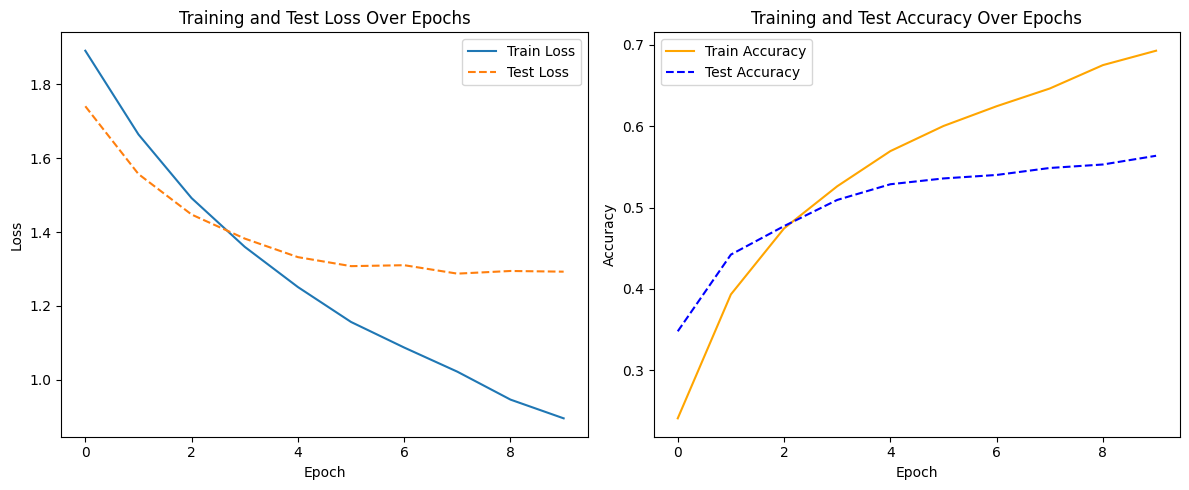

In [ ]:
## 11. 학습 손실 및 정확도 시각화
plt.figure(figsize=(12, 5))

# 학습 손실 및 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()

# 학습 정확도 및 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='orange')
plt.plot(test_accuracies, label='Test Accuracy', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


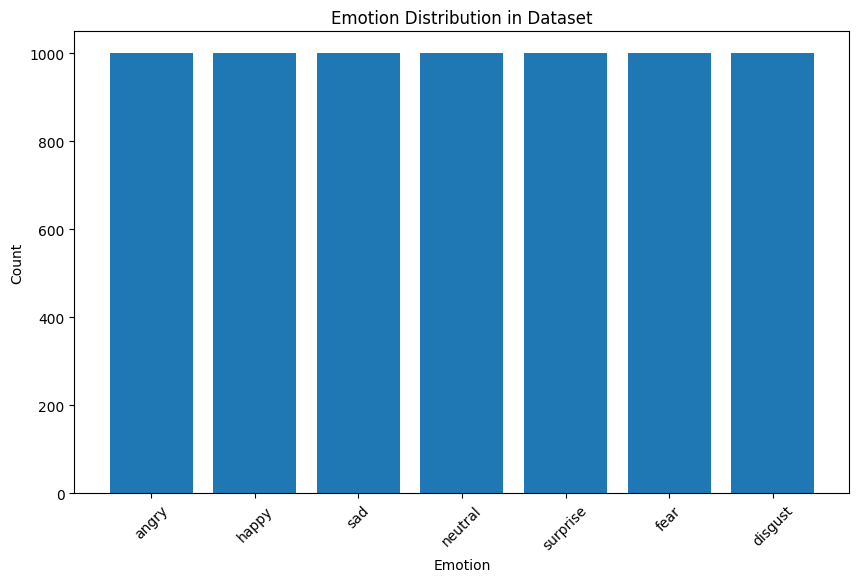

In [ ]:
# 감정별 데이터 분포 확인
import matplotlib.pyplot as plt

emotion_dict_rev = {v: k for k, v in emotion_dict.items()}

# 각 감정 레이블의 개수 확인
emotion_counts = labels_df['emotion_numeric'].value_counts()

# 감정별 데이터 개수 시각화
plt.figure(figsize=(10, 6))
plt.bar([emotion_dict_rev[label] for label in emotion_counts.index], emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()
